# Ejemplo de problema típico de clasificación de textos

En este ejemplo se elige un dataset de clasificación de texto y se explican los principales pasos que se suelen llevar a cabo a la hora de obtener los mejores resultados, desde la obtención de un baseline rápido a un modelo del lenguaje finetuneado.

## Datos

[Coronavirus tweets NLP - Text Classification](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification]) es un dataset que consta de 40k tweets recogidos durante marzo de 2020 y etiquetados manualmente según el sentimiento expresado (relacionados con la pandemia, en general): `Extremadamente Negativo`, `Negativo`, `Neutro`, `Positivo`, `Extremadamente Positivo`.

Este tipo de tareas de clasificación de tweets son muy comunes en la industria ya que a las empresas les gusta saber el impacto de sus campañas o la imagen que los usuarios tienen de ellos.

In [1]:
import numpy as np
import pandas as pd
train = pd.read_csv("datos/Corona_NLP_train.csv", encoding="latin-1")
test = pd.read_csv("datos/Corona_NLP_test.csv", encoding="latin-1")
cuantos = 5000
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


<AxesSubplot:>

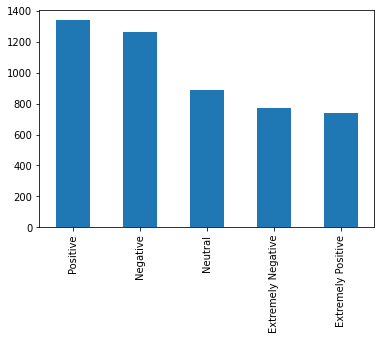

In [2]:
train["Sentiment"][:cuantos].value_counts().plot(kind='bar')

Las etiquetas están relativamente equilibradas.

In [3]:
label2id = {
    "Extremely Negative": 0,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 3,
    "Extremely Positive": 4,
}

X_train = train["OriginalTweet"][:cuantos]
y_train = train["Sentiment"].apply(lambda x: label2id[x])[:cuantos]
X_test = test["OriginalTweet"][:cuantos]
y_test = test["Sentiment"].apply(lambda x: label2id[x])[:cuantos]

In [4]:
import warnings
warnings.filterwarnings('ignore') 


from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

## Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1)),
    ],
)

pipeline.fit(X_train, list(y_train))
print(classification_report(list(y_test), pipeline.predict(X_test), target_names=list(label2id), digits=3, zero_division=0))

                    precision    recall  f1-score   support

Extremely Negative      0.605     0.166     0.260       592
          Negative      0.384     0.514     0.440      1041
           Neutral      0.465     0.543     0.501       619
          Positive      0.341     0.507     0.407       947
Extremely Positive      0.667     0.124     0.208       599

          accuracy                          0.401      3798
         macro avg      0.492     0.371     0.363      3798
      weighted avg      0.465     0.401     0.377      3798



#### Búsqueda de parámetros

In [6]:
pipeline = Pipeline(
    [
        ("vectorizer", CountVectorizer()),
        ("classifier", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ],
)

params = {
    "vectorizer__ngram_range": [(1, 1), (1,3), (3, 3), (3,5), (5, 7)],
    "vectorizer__analyzer": ["word", "char", "char_wb"],
    "classifier__criterion": ["gini", "entropy"],
    "classifier__max_features": np.arange(0.1, 1, 0.01),
    "classifier__min_samples_leaf": np.arange(1, 11),
    "classifier__min_samples_split": np.arange(1, 17),
    "classifier__n_estimators": np.arange(10, 500),
}
# La f1 macro tiene en cuenta todas las clases por igual al hacer la media
search = RandomizedSearchCV(pipeline, params, scoring="f1_macro", cv=3, n_jobs=-1, n_iter=10)
search.fit(X_train, list(y_train))
print(search.best_params_)
print(classification_report(list(y_test), search.best_estimator_.predict(X_test), target_names=list(label2id), digits=3, zero_division=0))

{'vectorizer__ngram_range': (5, 7), 'vectorizer__analyzer': 'char_wb', 'classifier__n_estimators': 274, 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 0.24999999999999992, 'classifier__criterion': 'gini'}
                    precision    recall  f1-score   support

Extremely Negative      0.532     0.279     0.366       592
          Negative      0.415     0.456     0.435      1041
           Neutral      0.468     0.628     0.536       619
          Positive      0.366     0.442     0.401       947
Extremely Positive      0.560     0.344     0.426       599

          accuracy                          0.435      3798
         macro avg      0.468     0.430     0.433      3798
      weighted avg      0.453     0.435     0.431      3798



## TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
pipeline = Pipeline(
    [
        ("vectorizer", TfidfVectorizer()),
        ("classifier", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ],
)

pipeline.fit(X_train, list(y_train))
print(classification_report(list(y_test), pipeline.predict(X_test), target_names=list(label2id), digits=3, zero_division=0))

                    precision    recall  f1-score   support

Extremely Negative      0.535     0.193     0.283       592
          Negative      0.354     0.457     0.399      1041
           Neutral      0.435     0.494     0.463       619
          Positive      0.338     0.501     0.403       947
Extremely Positive      0.722     0.160     0.262       599

          accuracy                          0.386      3798
         macro avg      0.477     0.361     0.362      3798
      weighted avg      0.449     0.386     0.371      3798



In [7]:
pipeline = Pipeline(
    [
        ("vectorizer", TfidfVectorizer()),
        ("classifier", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ],
)

params = {
    "vectorizer__ngram_range": [(1, 1), (1,3), (3, 3), (3,5), (5, 7)],
    "vectorizer__analyzer": ["word", "char", "char_wb"],
    "classifier__criterion": ["gini", "entropy"],
    "classifier__max_features": np.arange(0.1, 1, 0.01),
    "classifier__min_samples_leaf": np.arange(1, 11),
    "classifier__min_samples_split": np.arange(1, 17),
    "classifier__n_estimators": np.arange(10, 500),
}
# La f1 macro tiene en cuenta todas las clases por igual al hacer la media
search = RandomizedSearchCV(pipeline, params, scoring="f1_macro", cv=3, n_jobs=-1, n_iter=10)
search.fit(X_train, list(y_train))
print(search.best_params_)
print(classification_report(list(y_test), search.best_estimator_.predict(X_test), target_names=list(label2id), digits=3, zero_division=0))

/home/guillem.garcia/.conda/envs/charla/lib/python3.9/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 42.66s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
/home/guillem.garcia/.conda/envs/charla/lib/python3.9/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 44.27s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so

{'vectorizer__ngram_range': (5, 7), 'vectorizer__analyzer': 'char_wb', 'classifier__n_estimators': 150, 'classifier__min_samples_split': 12, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 0.5999999999999998, 'classifier__criterion': 'entropy'}
                    precision    recall  f1-score   support

Extremely Negative      0.455     0.294     0.357       592
          Negative      0.401     0.390     0.396      1041
           Neutral      0.404     0.611     0.486       619
          Positive      0.346     0.393     0.368       947
Extremely Positive      0.522     0.342     0.413       599

          accuracy                          0.404      3798
         macro avg      0.426     0.406     0.404      3798
      weighted avg      0.415     0.404     0.400      3798



In [8]:
print(search.best_params_)
print(classification_report(list(y_test), search.best_estimator_.predict(X_test), target_names=list(label2id), digits=3, zero_division=0))

{'vectorizer__ngram_range': (5, 7), 'vectorizer__analyzer': 'char_wb', 'classifier__n_estimators': 150, 'classifier__min_samples_split': 12, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 0.5999999999999998, 'classifier__criterion': 'entropy'}
                    precision    recall  f1-score   support

Extremely Negative      0.455     0.294     0.357       592
          Negative      0.401     0.390     0.396      1041
           Neutral      0.404     0.611     0.486       619
          Positive      0.346     0.393     0.368       947
Extremely Positive      0.522     0.342     0.413       599

          accuracy                          0.404      3798
         macro avg      0.426     0.406     0.404      3798
      weighted avg      0.415     0.404     0.400      3798



## SpaCy (GloVe)

In [14]:
import spacy

nlp = spacy.load("en_core_web_md")

def vectorize(X):
    return [x.vector for x in nlp.pipe(X)]

X_train_vs = vectorize(X_train)
X_test_vs = vectorize(X_test)

In [15]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)

model.fit(X_train_vs, list(y_train))
print(classification_report(list(y_test), model.predict(X_test_vs), target_names=list(label2id), digits=3, zero_division=0))

                    precision    recall  f1-score   support

Extremely Negative      0.477     0.284     0.356       592
          Negative      0.348     0.458     0.396      1041
           Neutral      0.456     0.338     0.388       619
          Positive      0.300     0.460     0.364       947
Extremely Positive      0.536     0.150     0.235       599

          accuracy                          0.363      3798
         macro avg      0.424     0.338     0.348      3798
      weighted avg      0.404     0.363     0.355      3798



In [18]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)

params = {
    "criterion": ["gini", "entropy"],
    "max_features": np.arange(0.1, 1, 0.01),
    "min_samples_leaf": np.arange(1, 11),
    "min_samples_split": np.arange(1, 17),
    "n_estimators": np.arange(10, 500),
}
# La f1 macro tiene en cuenta todas las clases por igual al hacer la media
search = RandomizedSearchCV(model, params, scoring="f1_macro", cv=3, n_jobs=-1, n_iter=10)
search.fit(X_train_vs, list(y_train))
print(search.best_params_)
print(classification_report(list(y_test), search.best_estimator_.predict(X_test_vs), target_names=list(label2id), digits=3, zero_division=0))

{'n_estimators': 90, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 0.7499999999999997, 'criterion': 'entropy'}
                    precision    recall  f1-score   support

Extremely Negative      0.481     0.272     0.347       592
          Negative      0.369     0.459     0.409      1041
           Neutral      0.466     0.344     0.396       619
          Positive      0.311     0.477     0.376       947
Extremely Positive      0.512     0.219     0.306       599

          accuracy                          0.378      3798
         macro avg      0.428     0.354     0.367      3798
      weighted avg      0.410     0.378     0.373      3798



## Sentence-transformers

In [5]:
from sentence_transformers import SentenceTransformer
vectorizer = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")
X_train_vt = vectorizer.encode(X_train)
X_test_vt = vectorizer.encode(X_test)

In [13]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)

model.fit(X_train_vt, list(y_train))
print(classification_report(list(y_test), model.predict(X_test_vt), target_names=list(label2id), digits=3, zero_division=0))

                    precision    recall  f1-score   support

Extremely Negative      0.434     0.201     0.275       592
          Negative      0.342     0.505     0.408      1041
           Neutral      0.417     0.231     0.297       619
          Positive      0.305     0.507     0.380       947
Extremely Positive      0.500     0.057     0.102       599

          accuracy                          0.343      3798
         macro avg      0.400     0.300     0.293      3798
      weighted avg      0.384     0.343     0.314      3798



In [6]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)

params = {
    "criterion": ["gini", "entropy"],
    "max_features": np.arange(0.1, 1, 0.01),
    "min_samples_leaf": np.arange(1, 11),
    "min_samples_split": np.arange(1, 17),
    "n_estimators": np.arange(10, 500),
}
# La f1 macro tiene en cuenta todas las clases por igual al hacer la media
search = RandomizedSearchCV(model, params, scoring="f1_macro", cv=3, n_jobs=-1, n_iter=10)
search.fit(X_train_vt, list(y_train))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_features': array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
       0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31,
       0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42,
       0.43, 0.44, 0.45, 0.46, 0...
       413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425,
       426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438,
       439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451,
       452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464,
       465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477,
       478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490,
       491, 492, 493, 494, 495, 496, 497, 498, 

In [7]:
print(search.best_params_)
print(classification_report(list(y_test), search.best_estimator_.predict(X_test_vt), target_names=list(label2id), digits=3, zero_division=0))

{'n_estimators': 294, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 0.4999999999999998, 'criterion': 'entropy'}
                    precision    recall  f1-score   support

Extremely Negative      0.473     0.264     0.338       592
          Negative      0.353     0.487     0.409      1041
           Neutral      0.476     0.288     0.359       619
          Positive      0.324     0.545     0.406       947
Extremely Positive      0.613     0.063     0.115       599

          accuracy                          0.367      3798
         macro avg      0.448     0.329     0.325      3798
      weighted avg      0.425     0.367     0.343      3798



A parte del Random Forest, las SVM lineares suelen dar resultados bastante buenos en problemas donde la carga gramatical es menor y, por lo tanto, son fáciles de resolver con conteo de palabras y de forma lineal.

## Fine Tuning DistilBERT

**Imprescindible** tener una máquina con GPU, si no no vale la pena ni probar. Google colab es una buena opción gratuita.

Primero cargamos el modelo y el tokenizador, asignamos los parámetros que queremos que tenga la red y elegimos la métrica que vamos a usar.

In [38]:
import datasets
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    EarlyStoppingCallback,
    TrainingArguments,
    Trainer,
)

model_name = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False, model_max_length=512)
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(label2id),
    hidden_dropout_prob=0.1, #
    label2id=label2id,
    id2label={i: t for t, i in label2id.items()},
    finetuning_task="sentiment-analysis",
    problem_type="single_label_classification",
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

args = TrainingArguments(
    output_dir="distil_prueba",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    num_train_epochs=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
)

metric = datasets.load_metric("f1")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels, average="macro")


loading configuration file https://huggingface.co/distilbert-base-cased/resolve/main/config.json from cache at /home/guillem.garcia/.cache/huggingface/transformers/ebe1ea24d11aa664488b8de5b21e33989008ca78f207d4e30ec6350b693f073f.302bfd1b5e031cc1b17796e0b6e5b242ba2045d31d00f97589e12b458ebff27a
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.18.0",
  "vocab_size": 28996
}

loading file https://huggingface.co/distilbert-base-cased/resolve/main/vocab.txt from cache at /home/guillem.garcia/.cache/huggingface/transformers/ba377304984dc63e3ede0e23a938bbbf04d5

Formateamos los datos para que estén en formato Dataset (también se podría usar un dataloader de pytorch o su equivalente de tensorflow).

In [39]:
from sklearn.model_selection import train_test_split

X_train_n, X_val, y_train_n, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

data = datasets.DatasetDict({
    "train": datasets.Dataset.from_dict({"text": X_train_n, "labels": y_train_n}),
    "validation": datasets.Dataset.from_dict({"text": X_val, "labels": y_val}),
})


def tokenize_and_create_labels(samples):
    tokenized = tokenizer(samples["text"], truncation=True)
    tokenized["labels"] = samples["labels"]
    return tokenized


tokenized_dataset = data.map(
    tokenize_and_create_labels,
    batched=True,
).remove_columns(["text"])

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Creamos el trainer y entrenamos.

In [40]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)],
)
trainer.train()

***** Running training *****
  Num examples = 4250
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2660


Epoch,Training Loss,Validation Loss,F1
1,1.268600,1.052580,0.565484
2,0.808000,0.948625,0.634166
3,0.485300,1.026981,0.660112
4,0.314600,1.291819,0.654723
5,0.218100,1.571378,0.664581
6,0.174500,1.540023,0.681019
7,0.117600,1.776358,0.677361
8,0.064400,1.845957,0.681624
9,0.039400,2.014678,0.676105


***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to distil_prueba/checkpoint-266
Configuration saved in distil_prueba/checkpoint-266/config.json
Model weights saved in distil_prueba/checkpoint-266/pytorch_model.bin
tokenizer config file saved in distil_prueba/checkpoint-266/tokenizer_config.json
Special tokens file saved in distil_prueba/checkpoint-266/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to distil_prueba/checkpoint-532
Configuration saved in distil_prueba/checkpoint-532/config.json
Model weights saved in distil_prueba/checkpoint-532/pytorch_model.bin
tokenizer config file saved in distil_prueba/checkpoint-532/tokenizer_config.json
Special tokens file saved in distil_prueba/checkpoint-532/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to distil_prueba/checkpoint-798
Configuration saved in dis

TrainOutput(global_step=2394, training_loss=0.3878119989744105, metrics={'train_runtime': 252.7338, 'train_samples_per_second': 168.161, 'train_steps_per_second': 10.525, 'total_flos': 1011932750879220.0, 'train_loss': 0.3878119989744105, 'epoch': 9.0})

In [53]:
test_f = datasets.Dataset.from_dict({"text": X_test, "labels": y_test})

tokenized_test = test_f.map(
    tokenize_and_create_labels,
    batched=True,
).remove_columns(["text"])

preds = trainer.predict(tokenized_test)
print(classification_report(list(y_test), np.argmax(preds.predictions, axis=1), target_names=list(label2id), digits=3, zero_division=0))

  0%|          | 0/4 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 3798
  Batch size = 16


                    precision    recall  f1-score   support

Extremely Negative      0.780     0.598     0.677       592
          Negative      0.600     0.679     0.637      1041
           Neutral      0.709     0.674     0.691       619
          Positive      0.557     0.668     0.608       947
Extremely Positive      0.787     0.581     0.669       599

          accuracy                          0.647      3798
         macro avg      0.687     0.640     0.656      3798
      weighted avg      0.665     0.647     0.650      3798



In [57]:
args = TrainingArguments(
    output_dir="distil_prueba",
    metric_for_best_model="eval_f1",
    eval_steps=500,
    disable_tqdm=True,
    load_best_model_at_end=True,
)
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16]), #32, 64
        "weight_decay": trial.suggest_float("weight_decay", 1e-12, 1e-1, log=True),
        "gradient_accumulation_steps": trial.suggest_categorical("gradient_accumulation_steps", [1, 2, 3]),
    }

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    model_init=model_init,
)

trainer.hyperparameter_search(
    direction="maximize", 
    backend="optuna", 
    n_trials=10,
    hp_space=hp_space,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
[I 2022-04-28 17:32:16,180] A new study created in memory with name: no-name-dbdcfb46-2056-42b4-8bf6-fc12d01af831
Trial:
loading weights file https://huggingface.co/distilbert-base-cased/resolve/main/pytorch_model.bin from cache at /home/guillem.garcia/.cache/huggingface/transformers/9c9f39769dba4c5fe379b4bc82973eb01297bd607954621434eb9f1bc85a23a0.06b428c87335c1bb22eae46fdab31c8286efa0aa09e898a7ac42ddf5c3f5dc19
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- Thi

{'loss': 1.5966, 'learning_rate': 2.1481699204200208e-05, 'epoch': 2.82}


Model weights saved in distil_prueba/run-0/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distil_prueba/run-0/checkpoint-500/tokenizer_config.json
Special tokens file saved in distil_prueba/run-0/checkpoint-500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 750
  Batch size = 8


{'train_runtime': 75.8467, 'train_samples_per_second': 168.102, 'train_steps_per_second': 7.001, 'train_loss': 1.5947526188220007, 'epoch': 3.0}


[I 2022-04-28 17:33:34,663] Trial 0 finished with value: 0.07982924226254001 and parameters: {'learning_rate': 0.00036796071862678424, 'per_device_train_batch_size': 8, 'weight_decay': 1.2130421786377446e-06, 'gradient_accumulation_steps': 3}. Best is trial 0 with value: 0.07982924226254001.
Trial:


{'eval_loss': 1.5910857915878296, 'eval_f1': 0.07982924226254001, 'eval_runtime': 1.3599, 'eval_samples_per_second': 551.53, 'eval_steps_per_second': 69.125, 'epoch': 3.0}


loading weights file https://huggingface.co/distilbert-base-cased/resolve/main/pytorch_model.bin from cache at /home/guillem.garcia/.cache/huggingface/transformers/9c9f39769dba4c5fe379b4bc82973eb01297bd607954621434eb9f1bc85a23a0.06b428c87335c1bb22eae46fdab31c8286efa0aa09e898a7ac42ddf5c3f5dc19
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing 

{'loss': 1.67, 'learning_rate': 0.003690051303775658, 'epoch': 0.94}


Model weights saved in distil_prueba/run-1/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distil_prueba/run-1/checkpoint-500/tokenizer_config.json
Special tokens file saved in distil_prueba/run-1/checkpoint-500/special_tokens_map.json
Saving model checkpoint to distil_prueba/run-1/checkpoint-1000
Configuration saved in distil_prueba/run-1/checkpoint-1000/config.json


{'loss': 1.5763, 'learning_rate': 0.002002013195918541, 'epoch': 1.88}


Model weights saved in distil_prueba/run-1/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in distil_prueba/run-1/checkpoint-1000/tokenizer_config.json
Special tokens file saved in distil_prueba/run-1/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to distil_prueba/run-1/checkpoint-1500
Configuration saved in distil_prueba/run-1/checkpoint-1500/config.json


{'loss': 1.5804, 'learning_rate': 0.00031397508806142374, 'epoch': 2.82}


Model weights saved in distil_prueba/run-1/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in distil_prueba/run-1/checkpoint-1500/tokenizer_config.json
Special tokens file saved in distil_prueba/run-1/checkpoint-1500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 750
  Batch size = 8


{'train_runtime': 114.6534, 'train_samples_per_second': 111.205, 'train_steps_per_second': 13.894, 'train_loss': 1.6063657809710696, 'epoch': 3.0}


[I 2022-04-28 17:35:32,054] Trial 1 finished with value: 0.07982924226254001 and parameters: {'learning_rate': 0.005378089411632775, 'per_device_train_batch_size': 4, 'weight_decay': 2.696828352963448e-06, 'gradient_accumulation_steps': 2}. Best is trial 0 with value: 0.07982924226254001.
Trial:


{'eval_loss': 1.5909756422042847, 'eval_f1': 0.07982924226254001, 'eval_runtime': 1.3895, 'eval_samples_per_second': 539.746, 'eval_steps_per_second': 67.648, 'epoch': 3.0}


loading weights file https://huggingface.co/distilbert-base-cased/resolve/main/pytorch_model.bin from cache at /home/guillem.garcia/.cache/huggingface/transformers/9c9f39769dba4c5fe379b4bc82973eb01297bd607954621434eb9f1bc85a23a0.06b428c87335c1bb22eae46fdab31c8286efa0aa09e898a7ac42ddf5c3f5dc19
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing 

{'loss': 1.5997, 'learning_rate': 0.00010620800785466605, 'epoch': 1.88}


Model weights saved in distil_prueba/run-2/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distil_prueba/run-2/checkpoint-500/tokenizer_config.json
Special tokens file saved in distil_prueba/run-2/checkpoint-500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 750
  Batch size = 8


{'train_runtime': 75.7718, 'train_samples_per_second': 168.268, 'train_steps_per_second': 10.532, 'train_loss': 1.5926020342604559, 'epoch': 3.0}


[I 2022-04-28 17:36:50,335] Trial 2 finished with value: 0.07982924226254001 and parameters: {'learning_rate': 0.00028440936331551516, 'per_device_train_batch_size': 16, 'weight_decay': 2.5052861259104426e-05, 'gradient_accumulation_steps': 1}. Best is trial 0 with value: 0.07982924226254001.
Trial:


{'eval_loss': 1.590785264968872, 'eval_f1': 0.07982924226254001, 'eval_runtime': 1.3626, 'eval_samples_per_second': 550.42, 'eval_steps_per_second': 68.986, 'epoch': 3.0}


loading weights file https://huggingface.co/distilbert-base-cased/resolve/main/pytorch_model.bin from cache at /home/guillem.garcia/.cache/huggingface/transformers/9c9f39769dba4c5fe379b4bc82973eb01297bd607954621434eb9f1bc85a23a0.06b428c87335c1bb22eae46fdab31c8286efa0aa09e898a7ac42ddf5c3f5dc19
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing 

{'loss': 1.6184, 'learning_rate': 0.0005963159325331751, 'epoch': 0.94}


Model weights saved in distil_prueba/run-3/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distil_prueba/run-3/checkpoint-500/tokenizer_config.json
Special tokens file saved in distil_prueba/run-3/checkpoint-500/special_tokens_map.json
Saving model checkpoint to distil_prueba/run-3/checkpoint-1000
Configuration saved in distil_prueba/run-3/checkpoint-1000/config.json


{'loss': 1.5833, 'learning_rate': 0.0003235273083185479, 'epoch': 1.88}


Model weights saved in distil_prueba/run-3/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in distil_prueba/run-3/checkpoint-1000/tokenizer_config.json
Special tokens file saved in distil_prueba/run-3/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to distil_prueba/run-3/checkpoint-1500
Configuration saved in distil_prueba/run-3/checkpoint-1500/config.json


{'loss': 1.5831, 'learning_rate': 5.0738684103920655e-05, 'epoch': 2.82}


Model weights saved in distil_prueba/run-3/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in distil_prueba/run-3/checkpoint-1500/tokenizer_config.json
Special tokens file saved in distil_prueba/run-3/checkpoint-1500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 750
  Batch size = 8


{'train_runtime': 115.5909, 'train_samples_per_second': 110.303, 'train_steps_per_second': 13.781, 'train_loss': 1.5930328369140625, 'epoch': 3.0}


[I 2022-04-28 17:38:48,550] Trial 3 finished with value: 0.07982924226254001 and parameters: {'learning_rate': 0.0008691045567478023, 'per_device_train_batch_size': 4, 'weight_decay': 0.00911292051158684, 'gradient_accumulation_steps': 2}. Best is trial 0 with value: 0.07982924226254001.
Trial:


{'eval_loss': 1.591450572013855, 'eval_f1': 0.07982924226254001, 'eval_runtime': 1.388, 'eval_samples_per_second': 540.347, 'eval_steps_per_second': 67.723, 'epoch': 3.0}


loading weights file https://huggingface.co/distilbert-base-cased/resolve/main/pytorch_model.bin from cache at /home/guillem.garcia/.cache/huggingface/transformers/9c9f39769dba4c5fe379b4bc82973eb01297bd607954621434eb9f1bc85a23a0.06b428c87335c1bb22eae46fdab31c8286efa0aa09e898a7ac42ddf5c3f5dc19
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing 

{'loss': 1.5981, 'learning_rate': 0.00032718313755448504, 'epoch': 1.88}


Model weights saved in distil_prueba/run-4/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distil_prueba/run-4/checkpoint-500/tokenizer_config.json
Special tokens file saved in distil_prueba/run-4/checkpoint-500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 750
  Batch size = 8


{'train_runtime': 80.957, 'train_samples_per_second': 157.491, 'train_steps_per_second': 9.857, 'train_loss': 1.5914098218568884, 'epoch': 3.0}


[I 2022-04-28 17:40:12,033] Trial 4 finished with value: 0.07982924226254001 and parameters: {'learning_rate': 0.000876148133451272, 'per_device_train_batch_size': 8, 'weight_decay': 0.0033240874724519863, 'gradient_accumulation_steps': 2}. Best is trial 0 with value: 0.07982924226254001.
Trial:


{'eval_loss': 1.5917277336120605, 'eval_f1': 0.07982924226254001, 'eval_runtime': 1.3563, 'eval_samples_per_second': 552.956, 'eval_steps_per_second': 69.304, 'epoch': 3.0}


loading weights file https://huggingface.co/distilbert-base-cased/resolve/main/pytorch_model.bin from cache at /home/guillem.garcia/.cache/huggingface/transformers/9c9f39769dba4c5fe379b4bc82973eb01297bd607954621434eb9f1bc85a23a0.06b428c87335c1bb22eae46fdab31c8286efa0aa09e898a7ac42ddf5c3f5dc19
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing 

{'train_runtime': 65.9639, 'train_samples_per_second': 193.287, 'train_steps_per_second': 4.002, 'train_loss': 1.6081233169093276, 'epoch': 2.99}


[I 2022-04-28 17:41:20,623] Trial 5 finished with value: 0.07982924226254001 and parameters: {'learning_rate': 0.0010831682697942382, 'per_device_train_batch_size': 16, 'weight_decay': 1.9139840516727824e-12, 'gradient_accumulation_steps': 3}. Best is trial 0 with value: 0.07982924226254001.
Trial:


{'eval_loss': 1.5913418531417847, 'eval_f1': 0.07982924226254001, 'eval_runtime': 1.3811, 'eval_samples_per_second': 543.04, 'eval_steps_per_second': 68.061, 'epoch': 2.99}


loading weights file https://huggingface.co/distilbert-base-cased/resolve/main/pytorch_model.bin from cache at /home/guillem.garcia/.cache/huggingface/transformers/9c9f39769dba4c5fe379b4bc82973eb01297bd607954621434eb9f1bc85a23a0.06b428c87335c1bb22eae46fdab31c8286efa0aa09e898a7ac42ddf5c3f5dc19
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing 

{'loss': 1.6307, 'learning_rate': 0.0003147748411202089, 'epoch': 2.82}


Model weights saved in distil_prueba/run-6/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distil_prueba/run-6/checkpoint-500/tokenizer_config.json
Special tokens file saved in distil_prueba/run-6/checkpoint-500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 750
  Batch size = 8


{'train_runtime': 76.5083, 'train_samples_per_second': 166.649, 'train_steps_per_second': 6.94, 'train_loss': 1.6269346262326574, 'epoch': 3.0}


[I 2022-04-28 17:42:39,691] Trial 6 finished with value: 0.07982924226254001 and parameters: {'learning_rate': 0.005391788407575191, 'per_device_train_batch_size': 8, 'weight_decay': 4.462278192301384e-07, 'gradient_accumulation_steps': 3}. Best is trial 0 with value: 0.07982924226254001.
Trial:


{'eval_loss': 1.590257167816162, 'eval_f1': 0.07982924226254001, 'eval_runtime': 1.3643, 'eval_samples_per_second': 549.723, 'eval_steps_per_second': 68.899, 'epoch': 3.0}


loading weights file https://huggingface.co/distilbert-base-cased/resolve/main/pytorch_model.bin from cache at /home/guillem.garcia/.cache/huggingface/transformers/9c9f39769dba4c5fe379b4bc82973eb01297bd607954621434eb9f1bc85a23a0.06b428c87335c1bb22eae46fdab31c8286efa0aa09e898a7ac42ddf5c3f5dc19
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing 

{'loss': 1.5928, 'learning_rate': 0.00012690279631802159, 'epoch': 1.41}


Model weights saved in distil_prueba/run-7/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distil_prueba/run-7/checkpoint-500/tokenizer_config.json
Special tokens file saved in distil_prueba/run-7/checkpoint-500/special_tokens_map.json
Saving model checkpoint to distil_prueba/run-7/checkpoint-1000
Configuration saved in distil_prueba/run-7/checkpoint-1000/config.json


{'loss': 1.5716, 'learning_rate': 1.3999952618714126e-05, 'epoch': 2.82}


Model weights saved in distil_prueba/run-7/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in distil_prueba/run-7/checkpoint-1000/tokenizer_config.json
Special tokens file saved in distil_prueba/run-7/checkpoint-1000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 750
  Batch size = 8


{'train_runtime': 104.9921, 'train_samples_per_second': 121.438, 'train_steps_per_second': 10.115, 'train_loss': 1.577808035295562, 'epoch': 3.0}


[I 2022-04-28 17:44:27,227] Trial 7 finished with value: 0.1432597239249152 and parameters: {'learning_rate': 0.00023980564001732906, 'per_device_train_batch_size': 4, 'weight_decay': 3.6985111737686066e-06, 'gradient_accumulation_steps': 3}. Best is trial 7 with value: 0.1432597239249152.
Trial:


{'eval_loss': 1.5501899719238281, 'eval_f1': 0.1432597239249152, 'eval_runtime': 1.3953, 'eval_samples_per_second': 537.535, 'eval_steps_per_second': 67.371, 'epoch': 3.0}


loading weights file https://huggingface.co/distilbert-base-cased/resolve/main/pytorch_model.bin from cache at /home/guillem.garcia/.cache/huggingface/transformers/9c9f39769dba4c5fe379b4bc82973eb01297bd607954621434eb9f1bc85a23a0.06b428c87335c1bb22eae46fdab31c8286efa0aa09e898a7ac42ddf5c3f5dc19
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing 

{'train_runtime': 67.8083, 'train_samples_per_second': 188.03, 'train_steps_per_second': 5.884, 'train_loss': 1.6355212983630953, 'epoch': 3.0}


[I 2022-04-28 17:45:37,691] Trial 8 finished with value: 0.07982924226254001 and parameters: {'learning_rate': 0.004300592930654281, 'per_device_train_batch_size': 16, 'weight_decay': 8.66154084540421e-12, 'gradient_accumulation_steps': 2}. Best is trial 7 with value: 0.1432597239249152.
Trial:


{'eval_loss': 1.5906915664672852, 'eval_f1': 0.07982924226254001, 'eval_runtime': 1.3713, 'eval_samples_per_second': 546.924, 'eval_steps_per_second': 68.548, 'epoch': 3.0}


loading weights file https://huggingface.co/distilbert-base-cased/resolve/main/pytorch_model.bin from cache at /home/guillem.garcia/.cache/huggingface/transformers/9c9f39769dba4c5fe379b4bc82973eb01297bd607954621434eb9f1bc85a23a0.06b428c87335c1bb22eae46fdab31c8286efa0aa09e898a7ac42ddf5c3f5dc19
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing 

{'loss': 1.6671, 'learning_rate': 0.0016417060246900728, 'epoch': 0.94}


Model weights saved in distil_prueba/run-9/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distil_prueba/run-9/checkpoint-500/tokenizer_config.json
Special tokens file saved in distil_prueba/run-9/checkpoint-500/special_tokens_map.json
Saving model checkpoint to distil_prueba/run-9/checkpoint-1000
Configuration saved in distil_prueba/run-9/checkpoint-1000/config.json


{'loss': 1.583, 'learning_rate': 0.0008906968642646049, 'epoch': 1.88}


Model weights saved in distil_prueba/run-9/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in distil_prueba/run-9/checkpoint-1000/tokenizer_config.json
Special tokens file saved in distil_prueba/run-9/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to distil_prueba/run-9/checkpoint-1500
Configuration saved in distil_prueba/run-9/checkpoint-1500/config.json


{'loss': 1.5828, 'learning_rate': 0.00013968770383913703, 'epoch': 2.82}


Model weights saved in distil_prueba/run-9/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in distil_prueba/run-9/checkpoint-1500/tokenizer_config.json
Special tokens file saved in distil_prueba/run-9/checkpoint-1500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 750
  Batch size = 8


{'train_runtime': 114.9728, 'train_samples_per_second': 110.896, 'train_steps_per_second': 13.855, 'train_loss': 1.6082832446580253, 'epoch': 3.0}


[I 2022-04-28 17:47:35,301] Trial 9 finished with value: 0.07982924226254001 and parameters: {'learning_rate': 0.0023927151851155406, 'per_device_train_batch_size': 4, 'weight_decay': 2.0132350183619526e-10, 'gradient_accumulation_steps': 2}. Best is trial 7 with value: 0.1432597239249152.


{'eval_loss': 1.5902090072631836, 'eval_f1': 0.07982924226254001, 'eval_runtime': 1.3893, 'eval_samples_per_second': 539.842, 'eval_steps_per_second': 67.66, 'epoch': 3.0}


BestRun(run_id='7', objective=0.1432597239249152, hyperparameters={'learning_rate': 0.00023980564001732906, 'per_device_train_batch_size': 4, 'weight_decay': 3.6985111737686066e-06, 'gradient_accumulation_steps': 3})

## Posibles mejoras
* Data augmentation
* Usar modelos más grandes
* Usar modelos entrenados con tweets solo